In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 37.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 13.2 MB/s eta 0:00:00


In [ ]:
#import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import datasets, layers, models
import inspect

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Download and pre-process images

In [ ]:
#to access the data file from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# image_path = "/content/drive/MyDrive/IMG_SEL"
image_path = "drive/MyDrive/IMGS-TESIS-NUEVAS/Imagenes catalogadas" # path of the image
image_list = os.listdir(image_path) #to obtain a list of the image's name

In [ ]:
len(image_list)

47

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
import os


image_path = "drive/MyDrive/IMGS-TESIS-NUEVAS/Imagenes catalogadas"
image_list = os.listdir(image_path)

images = []
labels = []


for image_name in image_list:
    path = os.path.join(image_path, image_name)
    image = Image.open(path,)
    image = image.resize((250, 250))

    if image.mode != 'L':
        image = image.convert('L')


    image_array = np.array(image)
    images.append(image_array)


    if image_name.startswith("PVA_MCC_0"):
        labels.append(33.18)
    elif image_name.startswith("PVA_MCC_1"):
        labels.append(18.87)
    elif image_name.startswith("PVA_MCC_3"):
        labels.append(18.74)
    elif image_name.startswith("PVA_MCC_5"):
        labels.append(14.23)


images = np.array(images)
labels = np.array(labels)


images = images.reshape(-1, 250, 250, 1)


datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=5,
    zoom_range=0.1,
    vertical_flip=True,
    fill_mode="wrap"
)


datagen.fit(images)


augmented_images = []
augmented_labels = []


for i in range(40):
    it = datagen.flow(images, labels, shuffle=False)
    batch_images, batch_labels = next(it)

    augmented_images.append(batch_images)
    augmented_labels.append(batch_labels)


augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)


final_images = np.concatenate((images, augmented_images))
final_labels = np.concatenate((labels, augmented_labels))

print("Final dataset size:", len(final_images))

Final dataset size: 1327


Text(0.5, 0, '18.74')

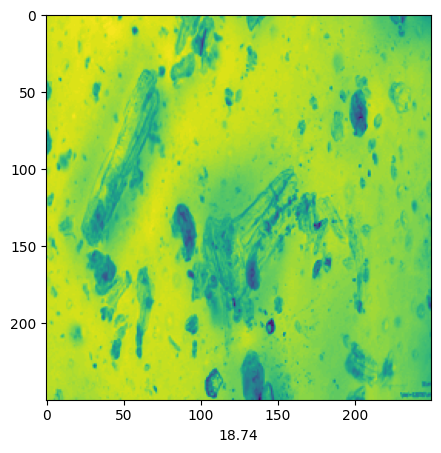

In [ ]:
#Plot the images
plt.figure(figsize=(5,5))
plt.imshow(images[17])
plt.xlabel(labels[17])

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(final_images, final_labels, test_size=0.3, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

In [ ]:
train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)

test_images = tf.convert_to_tensor((test_images), dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

val_images = tf.convert_to_tensor(val_images, dtype=tf.float32)
val_labels = tf.convert_to_tensor(val_labels, dtype=tf.float32)

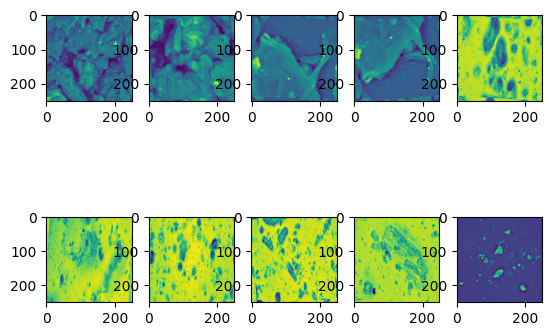

In [ ]:
#Plot the images
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(train_images[i])


tf.Tensor(14.23, shape=(), dtype=float32)


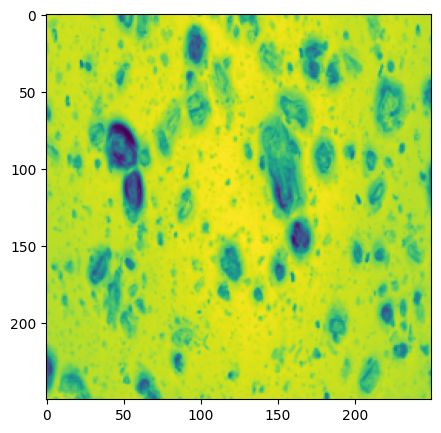

In [ ]:
#to plot the images
plt.figure(figsize=(5,5))
plt.imshow(train_images[10])
print(train_labels[10])

# HyperParameter Optimization

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from keras_tuner import HyperParameters, RandomSearch, Objective

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Reduce learning rate when a metric has stopped improving.
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Custom accuracy function for hit prediction (less than 5% of error)
def custom_accuracy(y_true, y_pred):
    error = tf.abs((y_true - y_pred) / tf.maximum(tf.abs(y_true), tf.keras.backend.epsilon()))  # Avoid division by zero
    return tf.reduce_mean(tf.cast(error < 0.05, tf.float32))  # 0.05 corresponds to 5% error

# CNN building function
def build_model(hp):
    model = models.Sequential()

    # L2 Regularization factor
    l2_reg = hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='LOG')

    # Tuning the number of filters for Conv2D layers
    model.add(layers.Conv2D(filters=hp.Int('filters_1', min_value=16, max_value=64, step=16),
                            kernel_size=(3, 3), strides=(1, 1),
                            padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(l2_reg),
                            input_shape=(250, 250, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.PReLU())
    model.add(layers.MaxPooling2D((5, 5), strides=(3, 3), padding='valid'))

    model.add(layers.Conv2D(filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
                            kernel_size=(5, 5), strides=(1, 1), padding='same',
                            kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.PReLU())
    model.add(layers.MaxPooling2D((5, 5), strides=(3, 3), padding='valid'))

    model.add(layers.Conv2D(filters=hp.Int('filters_3', min_value=64, max_value=256, step=64),
                            kernel_size=(3, 3), strides=(1, 1), padding='same',
                            kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.PReLU())
    model.add(layers.MaxPooling2D((5, 5), strides=(3, 3), padding='valid'))

    model.add(layers.Conv2D(filters=hp.Int('filters_4', min_value=128, max_value=512, step=128),
                            kernel_size=(3, 3), strides=(1, 1), padding='same',
                            kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.PReLU())
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid'))

    model.add(layers.Conv2D(filters=hp.Int('filters_5', min_value=256, max_value=1024, step=256),
                            kernel_size=(3, 3), strides=(1, 1), padding='same',
                            kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.PReLU())
    model.add(layers.AveragePooling2D((3, 3), strides=(2, 2), padding='valid'))

    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)))
    model.add(layers.Flatten())

    # Dense layer with L2 regularization
    model.add(layers.Dense(1, kernel_regularizer=regularizers.l2(l2_reg)))

    # Compile the model with a tunable learning rate during hyperparameter optimization
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mse',
                  metrics=[custom_accuracy])

    return model

# Initialize RandomSearch tuner with the custom accuracy hit objective
tuner = RandomSearch(
    build_model,
    objective=Objective('val_custom_accuracy', direction='max'),
    max_trials=10,
    executions_per_trial=2,
    directory='hyperparam_tuning',
    project_name='conv2d_tuning_acc_hit#1'
)

# Optimal hyperparameter search
tuner.search(train_images, train_labels,
             epochs=30,
             validation_data=(test_images, test_labels),
             batch_size=7,
             callbacks=[lr_scheduler, early_stopping])

Trial 10 Complete [00h 02m 14s]
val_custom_accuracy: 0.43701618909835815

Best val_custom_accuracy So Far: 0.45308470726013184
Total elapsed time: 00h 20m 52s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=2)[0]
model = tuner.hypermodel.build(best_hps)

In [ ]:
best_hps.values

{'l2_reg': 0.0001138595953062686,
 'filters_1': 32,
 'filters_2': 32,
 'filters_3': 192,
 'filters_4': 512,
 'filters_5': 1024,
 'dropout': 0.4,
 'learning_rate': 0.0004116104793878605}

0
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.2698 - mae: 0.7318 - mse: 1.0122 - val_loss: 4.9995 - val_mae: 1.4480 - val_mse: 4.7116
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.0965 - mae: 0.6837 - mse: 0.8113 - val_loss: 1.9178 - val_mae: 0.6426 - val_mse: 1.6417
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8952 - mae: 0.6080 - mse: 0.6213 - val_loss: 1.9601 - val_mae: 0.7267 - val_mse: 1.6891
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9073 - mae: 0.6189 - mse: 0.6372 - val_loss: 2.2347 - val_mae: 0.6330 - val_mse: 1.9653
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8358 - mae: 0.5781 - mse: 0.5680 - val_loss: 1.6047 - val_mae: 0.4546 - val_mse: 1.3389
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8547 - mae: 0.5692 - mse: 0.5898 - val_loss: 2.3588 - val_mae: 0.9189 - val_mse: 2.0961
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8207 - mae: 0.5663 - mse: 0.5593 - 

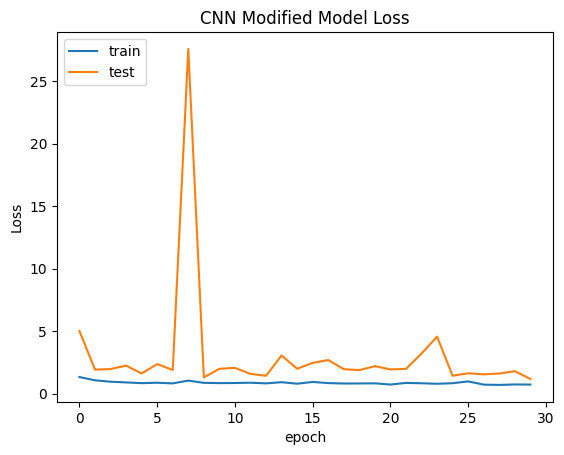

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
193
1
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7044 - mae: 0.5167 - mse: 0.4724 - val_loss: 2.0466 - val_mae: 0.5560 - val_mse: 1.8113
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7246 - mae: 0.5340 - mse: 0.4891 - val_loss: 1.9280 - val_mae: 0.7684 - val_mse: 1.6940
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6990 - mae: 0.5145 - mse: 0.4671 - val_loss: 1.2572 - val_mae: 0.4092 - val_mse: 1.0311
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8739 - mae: 0.6052 - mse: 0.6438 - val_loss: 1.8696 - val_mae: 0.7625 - val_mse: 1.6407
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7649 - mae: 0.5648 - mse: 0.5361 - val_loss: 1.3265 - val_mae: 0.5523 - val_mse: 1.0880
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7264 - mae: 0.5319 - mse: 0.4915 - val_loss: 1.5717 - val_mae: 0.4863 - val_mse: 1.3360
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step 

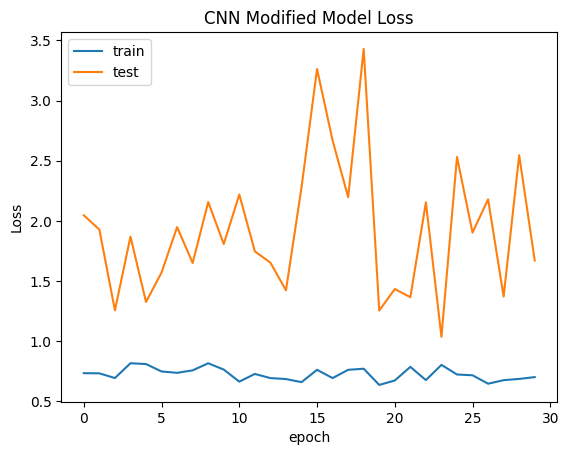

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
162
2
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7915 - mae: 0.5687 - mse: 0.5796 - val_loss: 3.2837 - val_mae: 1.1395 - val_mse: 3.0741
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5939 - mae: 0.4634 - mse: 0.3873 - val_loss: 1.9370 - val_mae: 0.6830 - val_mse: 1.7329
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6687 - mae: 0.5159 - mse: 0.4651 - val_loss: 4.7317 - val_mae: 1.6039 - val_mse: 4.5277
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6346 - mae: 0.5127 - mse: 0.4294 - val_loss: 1.7894 - val_mae: 0.6664 - val_mse: 1.5871
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6212 - mae: 0.4960 - mse: 0.4208 - val_loss: 2.5855 - val_mae: 0.8423 - val_mse: 2.3874
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5853 - mae: 0.4744 - mse: 0.3875 - val_loss: 2.7548 - val_mae: 0.9656 - val_mse: 2.5567
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step 

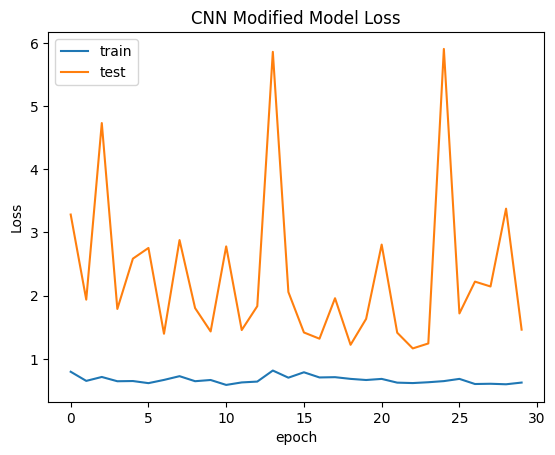

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
181
3
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8500 - mae: 0.6001 - mse: 0.6611 - val_loss: 1.5106 - val_mae: 0.3592 - val_mse: 1.3218
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6305 - mae: 0.4945 - mse: 0.4432 - val_loss: 6.5535 - val_mae: 1.7756 - val_mse: 6.3669
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7983 - mae: 0.5796 - mse: 0.6038 - val_loss: 1.4186 - val_mae: 0.3632 - val_mse: 1.2245
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6010 - mae: 0.4863 - mse: 0.4092 - val_loss: 1.5507 - val_mae: 0.4704 - val_mse: 1.3633
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6415 - mae: 0.5042 - mse: 0.4547 - val_loss: 2.4444 - val_mae: 1.1579 - val_mse: 2.2590
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5665 - mae: 0.4841 - mse: 0.3825 - val_loss: 1.6558 - val_mae: 0.5386 - val_mse: 1.4738
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step 

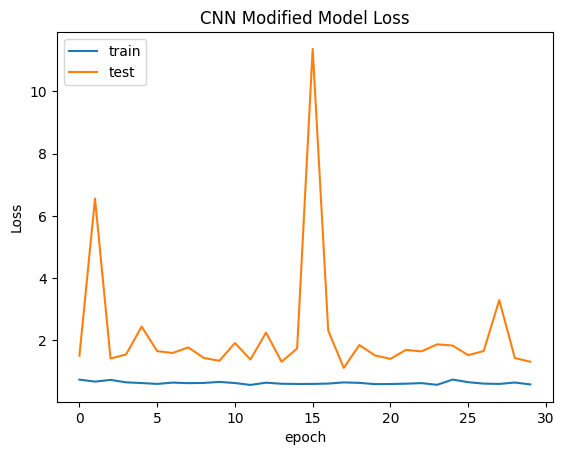

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
192
4
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5936 - mae: 0.5004 - mse: 0.4239 - val_loss: 1.4654 - val_mae: 0.3670 - val_mse: 1.2990
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5625 - mae: 0.4795 - mse: 0.3965 - val_loss: 2.2950 - val_mae: 0.7443 - val_mse: 2.1294
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6323 - mae: 0.4929 - mse: 0.4658 - val_loss: 2.2547 - val_mae: 0.9308 - val_mse: 2.0831
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5721 - mae: 0.4805 - mse: 0.4020 - val_loss: 1.2976 - val_mae: 0.4589 - val_mse: 1.1293
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5943 - mae: 0.4956 - mse: 0.4270 - val_loss: 1.5686 - val_mae: 0.7805 - val_mse: 1.3944
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6285 - mae: 0.5137 - mse: 0.4558 - val_loss: 3.3666 - val_mae: 1.0306 - val_mse: 3.2003
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step 

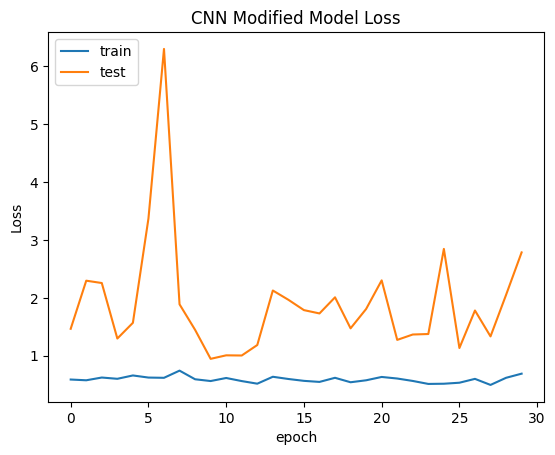

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
119
5
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5913 - mae: 0.4960 - mse: 0.4347 - val_loss: 1.1132 - val_mae: 0.4118 - val_mse: 0.9597
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6266 - mae: 0.4940 - mse: 0.4743 - val_loss: 1.1576 - val_mae: 0.3608 - val_mse: 1.0065
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5463 - mae: 0.4624 - mse: 0.3967 - val_loss: 1.1287 - val_mae: 0.3770 - val_mse: 0.9812
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5249 - mae: 0.4615 - mse: 0.3780 - val_loss: 0.9907 - val_mae: 0.3220 - val_mse: 0.8404
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5197 - mae: 0.4663 - mse: 0.3686 - val_loss: 1.2140 - val_mae: 0.4609 - val_mse: 1.0664
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5210 - mae: 0.4607 - mse: 0.3748 - val_loss: 1.7665 - val_mae: 0.5285 - val_mse: 1.6226
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step 

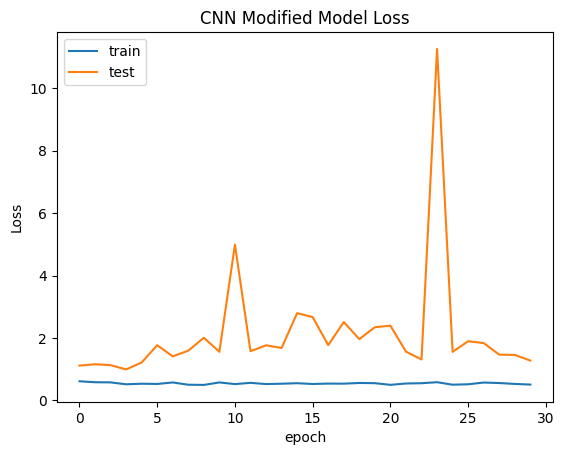

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
188
6
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4623 - mae: 0.4329 - mse: 0.3283 - val_loss: 1.2381 - val_mae: 0.5669 - val_mse: 1.1042
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5183 - mae: 0.4606 - mse: 0.3844 - val_loss: 1.7701 - val_mae: 0.5394 - val_mse: 1.6371
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6079 - mae: 0.4988 - mse: 0.4734 - val_loss: 1.7556 - val_mae: 0.5740 - val_mse: 1.6216
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5191 - mae: 0.4696 - mse: 0.3854 - val_loss: 1.1821 - val_mae: 0.3436 - val_mse: 1.0447
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4933 - mae: 0.4362 - mse: 0.3580 - val_loss: 1.3834 - val_mae: 0.4715 - val_mse: 1.2522
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4857 - mae: 0.4544 - mse: 0.3550 - val_loss: 1.6845 - val_mae: 0.8469 - val_mse: 1.5446
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step 

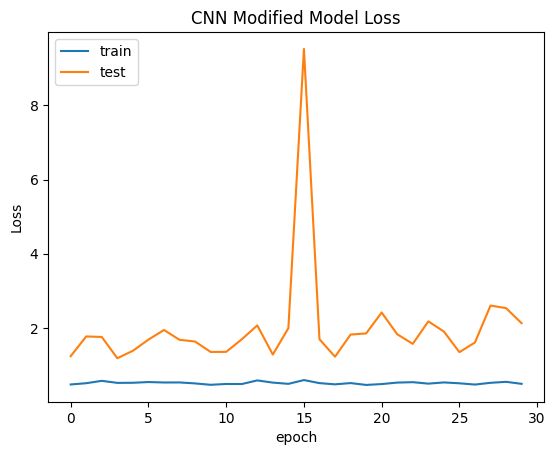

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
153
7
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4765 - mae: 0.4491 - mse: 0.3515 - val_loss: 1.1394 - val_mae: 0.6690 - val_mse: 1.0120
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4353 - mae: 0.4360 - mse: 0.3104 - val_loss: 1.9688 - val_mae: 0.6904 - val_mse: 1.8478
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5130 - mae: 0.4869 - mse: 0.3906 - val_loss: 1.6188 - val_mae: 0.6930 - val_mse: 1.4981
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5116 - mae: 0.4558 - mse: 0.3907 - val_loss: 1.9055 - val_mae: 0.7327 - val_mse: 1.7795
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4960 - mae: 0.4565 - mse: 0.3710 - val_loss: 1.9502 - val_mae: 0.7135 - val_mse: 1.8261
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4466 - mae: 0.4305 - mse: 0.3235 - val_loss: 2.6799 - val_mae: 0.9459 - val_mse: 2.5595
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step 

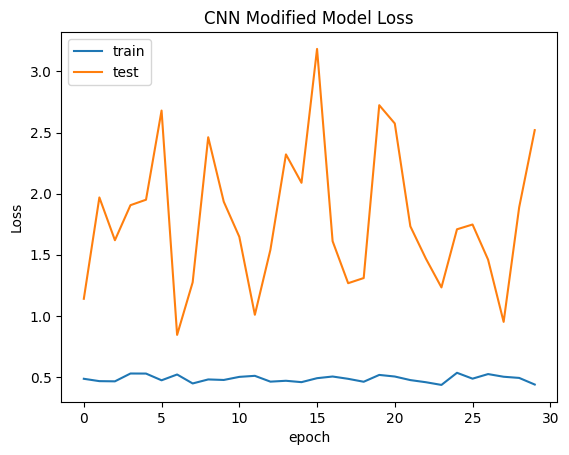

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
167
8
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4550 - mae: 0.4159 - mse: 0.3390 - val_loss: 1.5997 - val_mae: 0.4851 - val_mse: 1.4832
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4250 - mae: 0.4208 - mse: 0.3087 - val_loss: 1.8635 - val_mae: 0.5465 - val_mse: 1.7478
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4600 - mae: 0.4316 - mse: 0.3448 - val_loss: 1.7320 - val_mae: 0.5008 - val_mse: 1.6173
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5348 - mae: 0.4729 - mse: 0.4186 - val_loss: 1.9149 - val_mae: 0.6808 - val_mse: 1.7911
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5182 - mae: 0.4646 - mse: 0.3962 - val_loss: 1.6179 - val_mae: 0.5171 - val_mse: 1.5002
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4473 - mae: 0.4294 - mse: 0.3296 - val_loss: 1.6249 - val_mae: 0.4676 - val_mse: 1.5066
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step 

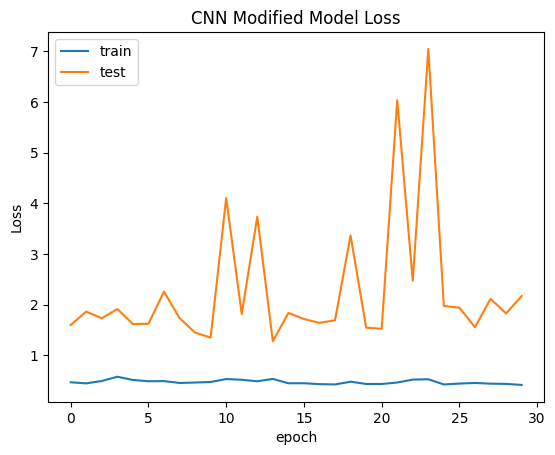

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
178
9
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4380 - mae: 0.4350 - mse: 0.3304 - val_loss: 1.4875 - val_mae: 0.4747 - val_mse: 1.3809
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4014 - mae: 0.4064 - mse: 0.2951 - val_loss: 2.5659 - val_mae: 0.8429 - val_mse: 2.4609
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3676 - mae: 0.3880 - mse: 0.2630 - val_loss: 2.0068 - val_mae: 0.5752 - val_mse: 1.9022
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4538 - mae: 0.4318 - mse: 0.3472 - val_loss: 1.8443 - val_mae: 0.4731 - val_mse: 1.7345
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4434 - mae: 0.4374 - mse: 0.3347 - val_loss: 1.3841 - val_mae: 0.4308 - val_mse: 1.2783
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3943 - mae: 0.4079 - mse: 0.2891 - val_loss: 2.0459 - val_mae: 0.7753 - val_mse: 1.9377
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step 

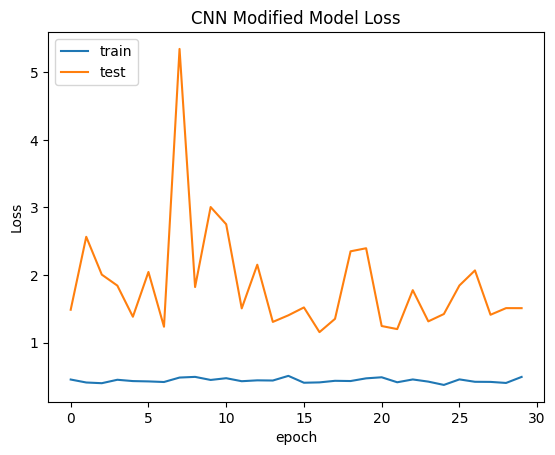

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
177
10
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5072 - mae: 0.4548 - mse: 0.3994 - val_loss: 1.3798 - val_mae: 0.6202 - val_mse: 1.2747
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4516 - mae: 0.4442 - mse: 0.3448 - val_loss: 1.6054 - val_mae: 0.5640 - val_mse: 1.5034
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4367 - mae: 0.4347 - mse: 0.3352 - val_loss: 1.2163 - val_mae: 0.4848 - val_mse: 1.1153
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4132 - mae: 0.4183 - mse: 0.3118 - val_loss: 1.8171 - val_mae: 0.7944 - val_mse: 1.7181
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4247 - mae: 0.4382 - mse: 0.3256 - val_loss: 1.0992 - val_mae: 0.5698 - val_mse: 0.9998
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4418 - mae: 0.4414 - mse: 0.3363 - val_loss: 1.4296 - val_mae: 0.5145 - val_mse: 1.3255
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

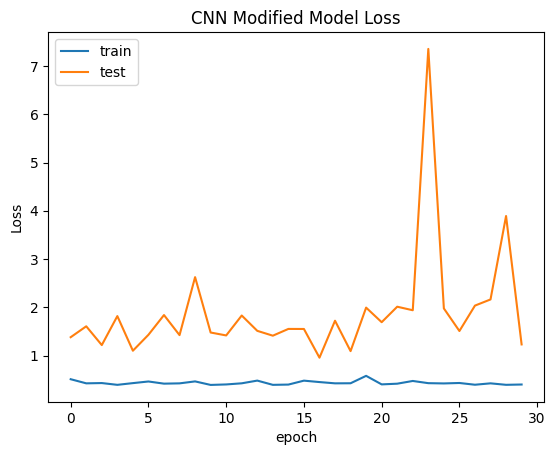

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
178
11
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4161 - mae: 0.4150 - mse: 0.3213 - val_loss: 1.5236 - val_mae: 0.5324 - val_mse: 1.4265
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4210 - mae: 0.4249 - mse: 0.3224 - val_loss: 1.3898 - val_mae: 0.5157 - val_mse: 1.2927
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4203 - mae: 0.4248 - mse: 0.3246 - val_loss: 2.1376 - val_mae: 0.5387 - val_mse: 2.0429
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4199 - mae: 0.4213 - mse: 0.3242 - val_loss: 2.4083 - val_mae: 0.9307 - val_mse: 2.3042
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4232 - mae: 0.4277 - mse: 0.3192 - val_loss: 1.9905 - val_mae: 0.5697 - val_mse: 1.8943
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4047 - mae: 0.4173 - mse: 0.3084 - val_loss: 5.0045 - val_mae: 1.2201 - val_mse: 4.9082
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

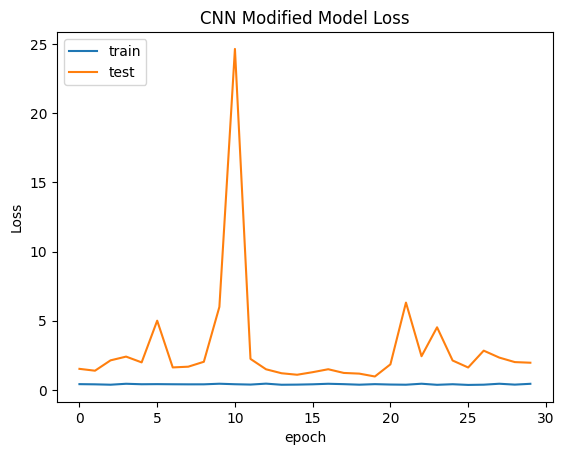

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
173
12
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3826 - mae: 0.3863 - mse: 0.2876 - val_loss: 2.7906 - val_mae: 0.7845 - val_mse: 2.6949
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3839 - mae: 0.3989 - mse: 0.2869 - val_loss: 1.2635 - val_mae: 0.6209 - val_mse: 1.1682
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3346 - mae: 0.3751 - mse: 0.2395 - val_loss: 1.4093 - val_mae: 0.5213 - val_mse: 1.3133
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3554 - mae: 0.3911 - mse: 0.2600 - val_loss: 1.3163 - val_mae: 0.3753 - val_mse: 1.2248
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3457 - mae: 0.3689 - mse: 0.2540 - val_loss: 4.0893 - val_mae: 1.0932 - val_mse: 3.9970
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4478 - mae: 0.4335 - mse: 0.3514 - val_loss: 1.3560 - val_mae: 0.4092 - val_mse: 1.2552
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

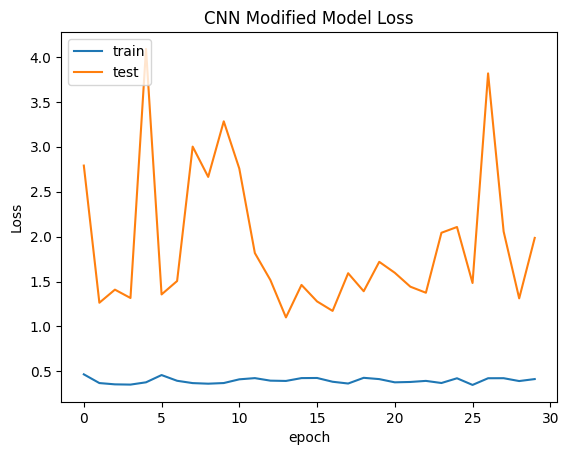

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
177
13
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3092 - mae: 0.3484 - mse: 0.2198 - val_loss: 1.3688 - val_mae: 0.4371 - val_mse: 1.2806
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3376 - mae: 0.3668 - mse: 0.2495 - val_loss: 1.3807 - val_mae: 0.3311 - val_mse: 1.2909
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3881 - mae: 0.4039 - mse: 0.2968 - val_loss: 1.4591 - val_mae: 0.6100 - val_mse: 1.3657
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4096 - mae: 0.4150 - mse: 0.3167 - val_loss: 1.9149 - val_mae: 0.6899 - val_mse: 1.8249
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3994 - mae: 0.4040 - mse: 0.3096 - val_loss: 1.5837 - val_mae: 0.4356 - val_mse: 1.4877
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3300 - mae: 0.3728 - mse: 0.2367 - val_loss: 1.3086 - val_mae: 0.3817 - val_mse: 1.2183
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

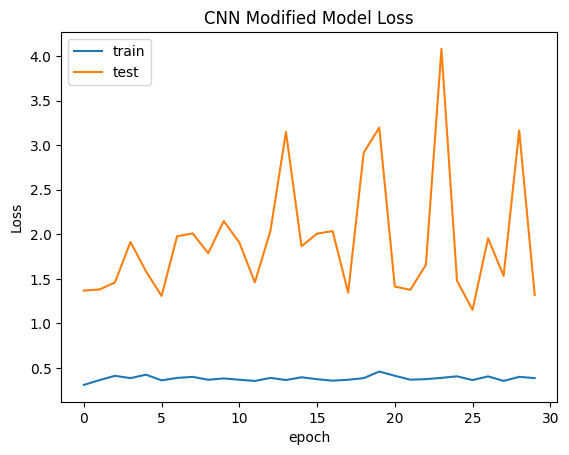

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
185
14
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3347 - mae: 0.3730 - mse: 0.2467 - val_loss: 3.4612 - val_mae: 1.0720 - val_mse: 3.3737
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4000 - mae: 0.4102 - mse: 0.3113 - val_loss: 3.4756 - val_mae: 1.0272 - val_mse: 3.3884
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3424 - mae: 0.3859 - mse: 0.2557 - val_loss: 1.6574 - val_mae: 0.5408 - val_mse: 1.5682
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3198 - mae: 0.3603 - mse: 0.2308 - val_loss: 2.2936 - val_mae: 0.6573 - val_mse: 2.2025
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3862 - mae: 0.3970 - mse: 0.2961 - val_loss: 1.5022 - val_mae: 0.5437 - val_mse: 1.3976
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3588 - mae: 0.3870 - mse: 0.2626 - val_loss: 1.3526 - val_mae: 0.5157 - val_mse: 1.2635
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

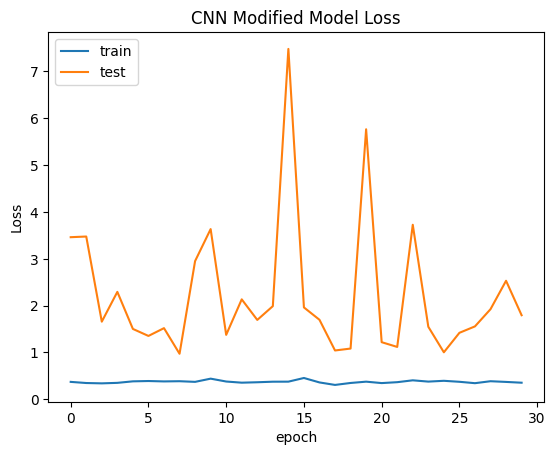

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
187
15
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3324 - mae: 0.3698 - mse: 0.2477 - val_loss: 1.6050 - val_mae: 0.5386 - val_mse: 1.5214
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3922 - mae: 0.4144 - mse: 0.3066 - val_loss: 2.4611 - val_mae: 0.8102 - val_mse: 2.3710
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3389 - mae: 0.3630 - mse: 0.2508 - val_loss: 3.6930 - val_mae: 1.2427 - val_mse: 3.6085
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3173 - mae: 0.3474 - mse: 0.2334 - val_loss: 2.0273 - val_mae: 0.7143 - val_mse: 1.9435
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3996 - mae: 0.4014 - mse: 0.3115 - val_loss: 1.2749 - val_mae: 0.4648 - val_mse: 1.1875
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3609 - mae: 0.3778 - mse: 0.2743 - val_loss: 6.9880 - val_mae: 1.8881 - val_mse: 6.9029
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

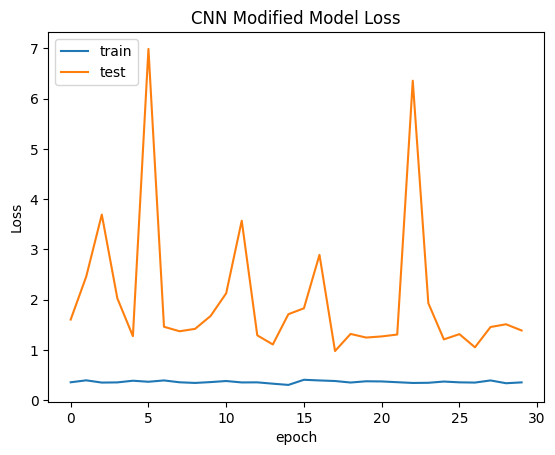

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
187
16
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3718 - mae: 0.3966 - mse: 0.2882 - val_loss: 0.9465 - val_mae: 0.4915 - val_mse: 0.8611
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3572 - mae: 0.3841 - mse: 0.2730 - val_loss: 1.3865 - val_mae: 0.4335 - val_mse: 1.3042
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3400 - mae: 0.3794 - mse: 0.2574 - val_loss: 1.3026 - val_mae: 0.4079 - val_mse: 1.2184
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3090 - mae: 0.3583 - mse: 0.2254 - val_loss: 1.2573 - val_mae: 0.3484 - val_mse: 1.1754
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2971 - mae: 0.3488 - mse: 0.2156 - val_loss: 1.2951 - val_mae: 0.3609 - val_mse: 1.2145
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3543 - mae: 0.3727 - mse: 0.2736 - val_loss: 1.1241 - val_mae: 0.4799 - val_mse: 1.0428
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

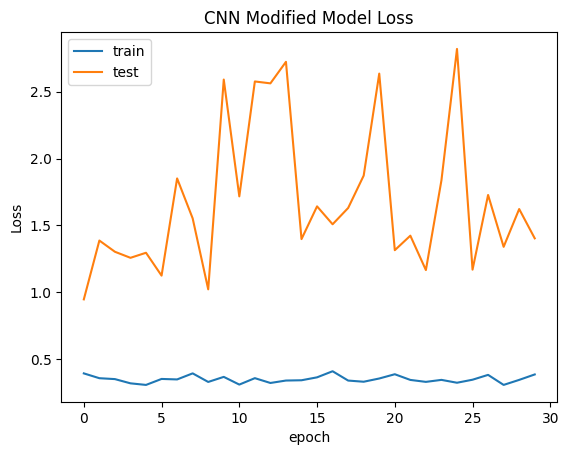

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
185
17
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3531 - mae: 0.3734 - mse: 0.2705 - val_loss: 2.1217 - val_mae: 0.5262 - val_mse: 2.0416
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2870 - mae: 0.3434 - mse: 0.2075 - val_loss: 1.2303 - val_mae: 0.4486 - val_mse: 1.1520
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3071 - mae: 0.3634 - mse: 0.2290 - val_loss: 1.8457 - val_mae: 0.5812 - val_mse: 1.7671
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3262 - mae: 0.3720 - mse: 0.2478 - val_loss: 2.1556 - val_mae: 0.6744 - val_mse: 2.0766
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3214 - mae: 0.3603 - mse: 0.2428 - val_loss: 2.0258 - val_mae: 0.4859 - val_mse: 1.9441
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3527 - mae: 0.3806 - mse: 0.2704 - val_loss: 1.6084 - val_mae: 0.4070 - val_mse: 1.5268
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

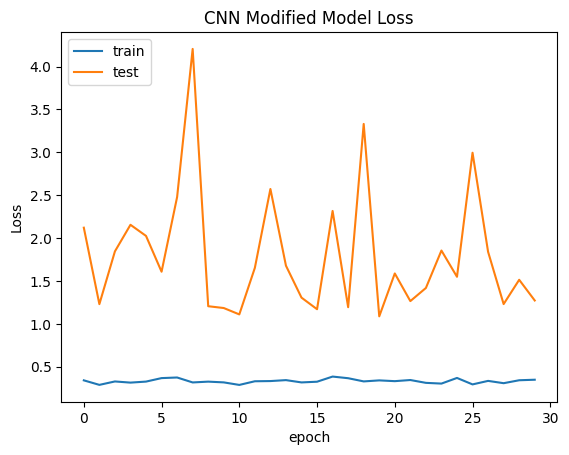

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
186
18
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3315 - mae: 0.3584 - mse: 0.2555 - val_loss: 1.8445 - val_mae: 0.5500 - val_mse: 1.7688
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4260 - mae: 0.3952 - mse: 0.3484 - val_loss: 1.3544 - val_mae: 0.4160 - val_mse: 1.2753
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3105 - mae: 0.3533 - mse: 0.2316 - val_loss: 1.0125 - val_mae: 0.3604 - val_mse: 0.9348
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3339 - mae: 0.3698 - mse: 0.2559 - val_loss: 1.6025 - val_mae: 0.4332 - val_mse: 1.5226
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3074 - mae: 0.3612 - mse: 0.2294 - val_loss: 1.9097 - val_mae: 0.8293 - val_mse: 1.8334
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3093 - mae: 0.3618 - mse: 0.2331 - val_loss: 2.1481 - val_mae: 0.7837 - val_mse: 2.0704
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

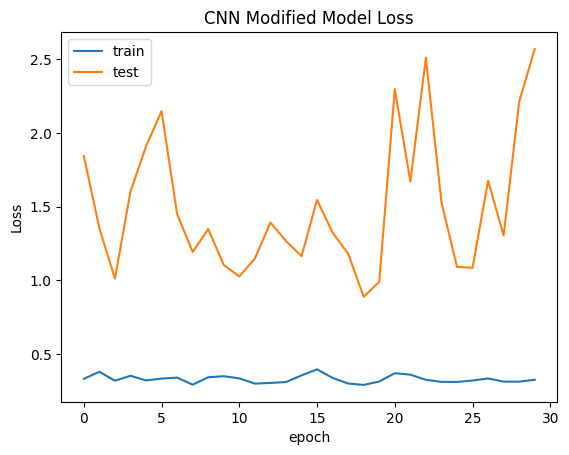

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
152
19
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2885 - mae: 0.3393 - mse: 0.2127 - val_loss: 1.3967 - val_mae: 0.3882 - val_mse: 1.3203
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3181 - mae: 0.3548 - mse: 0.2386 - val_loss: 0.8120 - val_mae: 0.3009 - val_mse: 0.7310
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3424 - mae: 0.3778 - mse: 0.2613 - val_loss: 1.5424 - val_mae: 0.4928 - val_mse: 1.4653
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3190 - mae: 0.3529 - mse: 0.2422 - val_loss: 1.7035 - val_mae: 0.5996 - val_mse: 1.6280
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3883 - mae: 0.3936 - mse: 0.3121 - val_loss: 1.0181 - val_mae: 0.3730 - val_mse: 0.9373
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3593 - mae: 0.3651 - mse: 0.2777 - val_loss: 1.6666 - val_mae: 0.5190 - val_mse: 1.5901
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

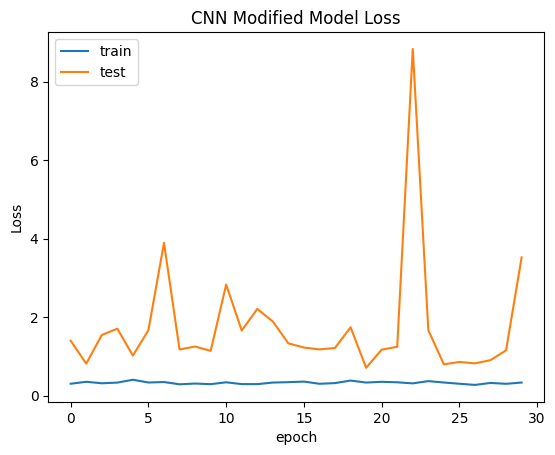

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
126
20
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3550 - mae: 0.3847 - mse: 0.2803 - val_loss: 1.1038 - val_mae: 0.6891 - val_mse: 1.0267
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3909 - mae: 0.3973 - mse: 0.3109 - val_loss: 1.8579 - val_mae: 0.6601 - val_mse: 1.7773
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3198 - mae: 0.3568 - mse: 0.2410 - val_loss: 1.6628 - val_mae: 0.7299 - val_mse: 1.5876
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3212 - mae: 0.3671 - mse: 0.2460 - val_loss: 1.2177 - val_mae: 0.6130 - val_mse: 1.1419
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3118 - mae: 0.3474 - mse: 0.2366 - val_loss: 1.2092 - val_mae: 0.5771 - val_mse: 1.1352
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3016 - mae: 0.3548 - mse: 0.2277 - val_loss: 1.4446 - val_mae: 0.4476 - val_mse: 1.3671
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

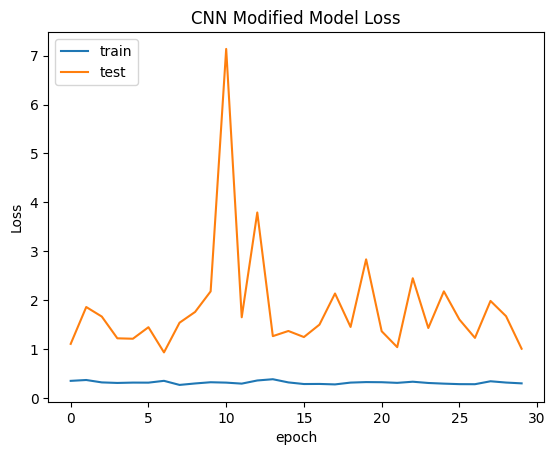

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
187
21
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2737 - mae: 0.3265 - mse: 0.2026 - val_loss: 1.3743 - val_mae: 0.3674 - val_mse: 1.3019
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2914 - mae: 0.3429 - mse: 0.2192 - val_loss: 1.4242 - val_mae: 0.4165 - val_mse: 1.3521
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3506 - mae: 0.3857 - mse: 0.2771 - val_loss: 1.1616 - val_mae: 0.4310 - val_mse: 1.0885
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3149 - mae: 0.3460 - mse: 0.2413 - val_loss: 1.0922 - val_mae: 0.4752 - val_mse: 1.0203
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3049 - mae: 0.3425 - mse: 0.2325 - val_loss: 1.4086 - val_mae: 0.4516 - val_mse: 1.3371
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3078 - mae: 0.3480 - mse: 0.2352 - val_loss: 2.4119 - val_mae: 0.8631 - val_mse: 2.3374
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

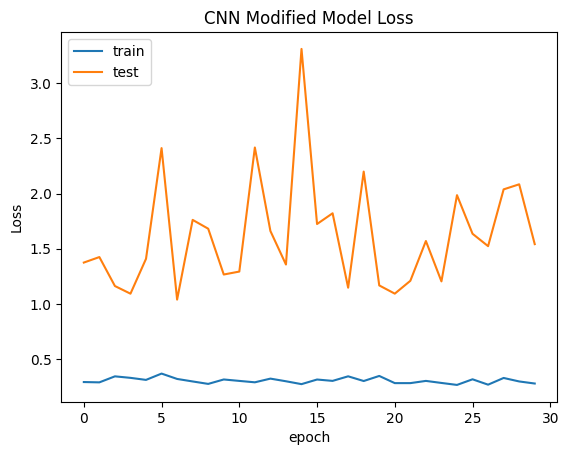

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
188
22
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3044 - mae: 0.3511 - mse: 0.2336 - val_loss: 2.6991 - val_mae: 0.7530 - val_mse: 2.6276
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3394 - mae: 0.3652 - mse: 0.2683 - val_loss: 2.1977 - val_mae: 0.6473 - val_mse: 2.1280
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2892 - mae: 0.3373 - mse: 0.2187 - val_loss: 1.7308 - val_mae: 0.6809 - val_mse: 1.6567
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3122 - mae: 0.3351 - mse: 0.2393 - val_loss: 1.9427 - val_mae: 0.5639 - val_mse: 1.8708
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3052 - mae: 0.3592 - mse: 0.2334 - val_loss: 1.7209 - val_mae: 0.6552 - val_mse: 1.6499
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2917 - mae: 0.3400 - mse: 0.2209 - val_loss: 1.5439 - val_mae: 0.5228 - val_mse: 1.4740
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

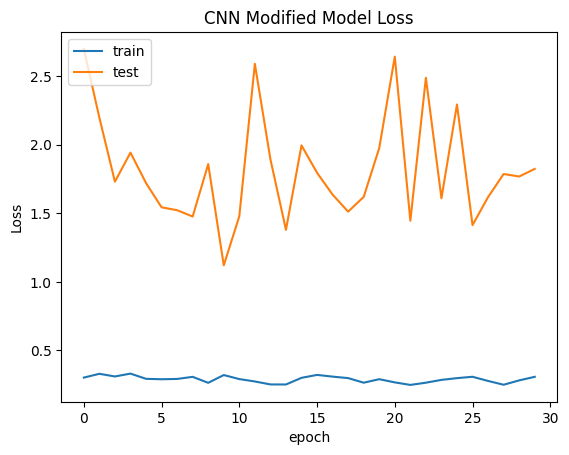

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
178
23
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3069 - mae: 0.3438 - mse: 0.2362 - val_loss: 2.2108 - val_mae: 0.7174 - val_mse: 2.1371
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3079 - mae: 0.3512 - mse: 0.2352 - val_loss: 1.3980 - val_mae: 0.5339 - val_mse: 1.3272
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2643 - mae: 0.3311 - mse: 0.1927 - val_loss: 1.1843 - val_mae: 0.3563 - val_mse: 1.1112
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2886 - mae: 0.3403 - mse: 0.2181 - val_loss: 1.3498 - val_mae: 0.4850 - val_mse: 1.2819
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2711 - mae: 0.3247 - mse: 0.2034 - val_loss: 0.9847 - val_mae: 0.3520 - val_mse: 0.9177
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2795 - mae: 0.3322 - mse: 0.2125 - val_loss: 1.1554 - val_mae: 0.3371 - val_mse: 1.0865
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

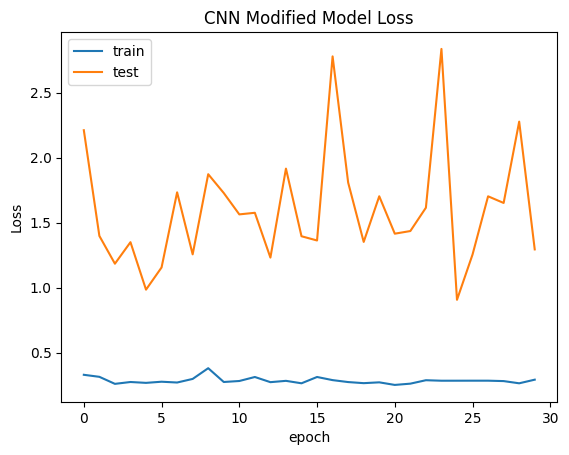

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
189
24
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2403 - mae: 0.2983 - mse: 0.1741 - val_loss: 1.9278 - val_mae: 0.5015 - val_mse: 1.8625
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2791 - mae: 0.3259 - mse: 0.2135 - val_loss: 2.1258 - val_mae: 0.5918 - val_mse: 2.0601
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2925 - mae: 0.3467 - mse: 0.2238 - val_loss: 2.3973 - val_mae: 0.7413 - val_mse: 2.3067
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2470 - mae: 0.2938 - mse: 0.1685 - val_loss: 1.1242 - val_mae: 0.4656 - val_mse: 1.0557
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2696 - mae: 0.3225 - mse: 0.2017 - val_loss: 1.0883 - val_mae: 0.4979 - val_mse: 1.0215
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2405 - mae: 0.2996 - mse: 0.1744 - val_loss: 1.2109 - val_mae: 0.4618 - val_mse: 1.1459
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

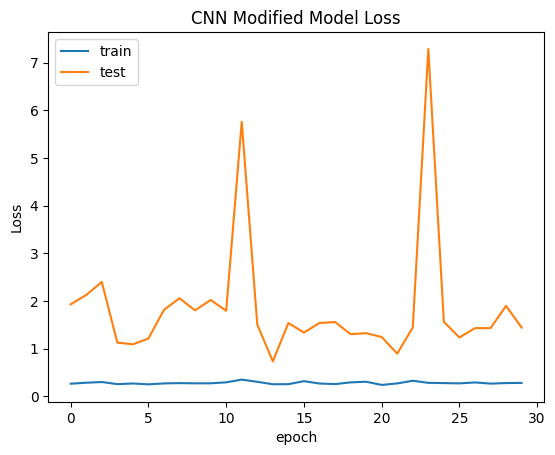

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
177


In [ ]:
l_model = []
l_hits, l_mae, l_mse, l_loss = [], [], [], []
for i in range(25):

  print(i)
  # Compile the model
  # model.compile(optimizer='adam',
  #               loss='mse',
  #               metrics=['mae', 'mse'])

  # Train the model
  history = model.fit(train_images, train_labels, epochs=30,
                      validation_data=(test_images, test_labels),
                      batch_size=3)

  # Evaluate the model
  test_loss = model.evaluate(test_images, test_labels)
  # print("Test MAE:", test_mae)

# summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('CNN Modified Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  predictions_test = model.predict(test_images)
  print(len(predictions_test))
  count = 0
  for i in range(len(predictions_test)):

    error = float(abs(predictions_test[i]-test_labels[i])*100/test_labels[i])
    if error <= 5.00:
      count += 1
      # print(predictions_test[i])
      # print(float(test_labels[i]))
      # print('% error: ', float(abs(predictions_test[i]-test_labels[i])*100/test_labels[i]))
      # print('#########\n')
  print(count)
  hits = round(count*100/len(predictions_test), 2)
  # print("hits: %", )
  l_hits.append(hits)
  l_loss.append(test_loss)
  # l_mae.append(test_mae)
  # l_mse.append(test_mse)
  # print("Test MSE:", test_mse)
  l_model.append(model)

In [ ]:
# Statistics
import statistics
mean = statistics.mean(l_hits)
mean_loss = statistics.mean(l_loss[0])
# mean_mae = statistics.mean(l_mae)
# mean_mse = statistics.mean(l_mse)

stdev = statistics.stdev(l_hits)
stdev_loss = statistics.stdev(l_loss[0])
# stdev_mae = statistics.stdev(l_mae)
# stdev_mse = statistics.stdev(l_mse)

print(f"Mean: {mean}")
print(f"Mean Loss: {mean_loss}")
# print(f"Mean MAE: {mean_mae}")
# print(f"Mean MSE: {mean_mse}")
print()
print(f"Standard Deviation: {stdev}")
print(f"Standard Deviation Loss: {stdev_loss}")
# print(f"Standard Deviation MAE: {stdev_mae}")
# print(f"Standard Deviation MSE: {stdev_mse}")

Mean: 87.7372
Mean Loss: 0.8208559155464172

Standard Deviation: 9.5983399259108
Standard Deviation Loss: 0.4110055215760322


Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - custom_accuracy: 0.5475 - loss: 0.5283 - val_custom_accuracy: 0.5821 - val_loss: 1.5809
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - custom_accuracy: 0.5650 - loss: 0.4966 - val_custom_accuracy: 0.4494 - val_loss: 2.1810
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - custom_accuracy: 0.5626 - loss: 0.4745 - val_custom_accuracy: 0.5738 - val_loss: 1.8102
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - custom_accuracy: 0.5533 - loss: 0.4756 - val_custom_accuracy: 0.5771 - val_loss: 1.4563
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - custom_accuracy: 0.5710 - loss: 0.4324 - val_custom_accuracy: 0.6053 - val_loss: 1.1770
Epoch 6/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - custom_accuracy: 0.5802 - loss: 0.3995 - val_custom_accuracy: 0.5887 - val_loss: 1.4537
Epoch 7/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - custom_accuracy: 0.5629 - loss: 0.4354 - val_custom_accuracy: 0.5307 - val_loss: 1.8036
Epoch 

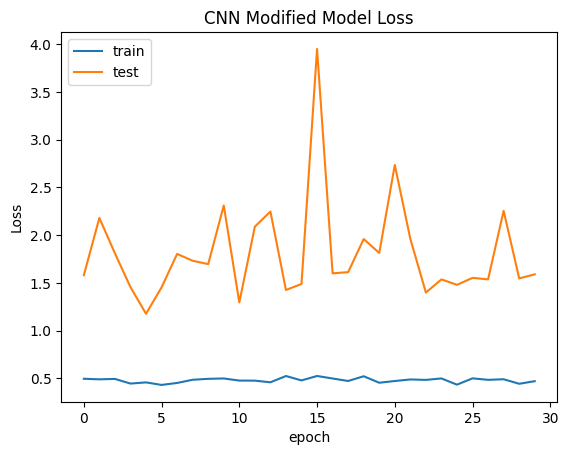

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
199
187


93.97

In [ ]:
history = model.fit(train_images, train_labels, epochs=30,
                      validation_data=(test_images, test_labels),
                      batch_size=3)
test_loss, test_mae = model.evaluate(test_images, test_labels)
print("Test MAE:", test_mae)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Modified Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
predictions_test = model.predict(test_images)
print(len(predictions_test))
count = 0
for i in range(len(predictions_test)):

  error = float(abs(predictions_test[i]-test_labels[i])*100/test_labels[i])
  if error <= 5.00:
    count += 1

print(count)
hits = round(count*100/len(predictions_test), 2)
hits

In [ ]:
model.save('optimized_hyperparameters_model.h5')

In [ ]:
!zip -r /content/file.zip /content/hyperparam_tuning

  adding: content/hyperparam_tuning/ (stored 0%)
  adding: content/hyperparam_tuning/conv2d_tuning_acc_hit/ (stored 0%)
  adding: content/hyperparam_tuning/conv2d_tuning_acc_hit/oracle.json (deflated 72%)
  adding: content/hyperparam_tuning/conv2d_tuning_acc_hit/trial_02/ (stored 0%)
  adding: content/hyperparam_tuning/conv2d_tuning_acc_hit/trial_02/checkpoint.weights.h5 (deflated 31%)
  adding: content/hyperparam_tuning/conv2d_tuning_acc_hit/trial_02/build_config.json (deflated 11%)
  adding: content/hyperparam_tuning/conv2d_tuning_acc_hit/trial_02/trial.json (deflated 74%)
  adding: content/hyperparam_tuning/conv2d_tuning_acc_hit/trial_00/ (stored 0%)
  adding: content/hyperparam_tuning/conv2d_tuning_acc_hit/trial_00/checkpoint.weights.h5 (deflated 36%)
  adding: content/hyperparam_tuning/conv2d_tuning_acc_hit/trial_00/build_config.json (deflated 11%)
  adding: content/hyperparam_tuning/conv2d_tuning_acc_hit/trial_00/trial.json (deflated 74%)
  adding: content/hyperparam_tuning/conv2

In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>